# Running Tests

In [1]:
from game.GridGeneration import DisjointBlobs
from htn.my_htn import DictBasedHTN
import matplotlib.pyplot as plt
import numpy as np

## Maze Complexity Analysis
The following code investigate how well the HTN performs as maze complexity increases for the current obstacles that means more blobs and greater blob masses.

In [22]:
max_counts = range(1, 11)
max_sizes = range(2, 21, 2)
num_episodes = 200
base_seed = 42

avg_lengths = np.zeros((len(max_sizes), len(max_counts)))

for i, max_size in enumerate(max_sizes):
    print(i)
    for j, max_count in enumerate(max_counts):
        lengths: list[int] = []
        for k in range(num_episodes):
            seed = base_seed + k
            obstacle_gen = DisjointBlobs(
                max_count=max_count,
                max_size=max_size,
            )
            game = DictBasedHTN(
                h=18,
                w=18,
                n=9,
                m=9,
                num_fake_targets=0,
                obstacle_scheme=obstacle_gen,
            )
            game_len = game.play_game(seed=seed)
            lengths.append(game_len)
        avg_lengths[i, j] = np.mean(lengths)
        print(f"max_count={max_count}, max_size={max_size} -> avg_len={avg_lengths[i,j]:.2f}")

0
max_count=1, max_size=2 -> avg_len=103.08
max_count=2, max_size=2 -> avg_len=104.06
max_count=3, max_size=2 -> avg_len=104.42
max_count=4, max_size=2 -> avg_len=103.25
max_count=5, max_size=2 -> avg_len=103.00
max_count=6, max_size=2 -> avg_len=101.62
max_count=7, max_size=2 -> avg_len=102.27
max_count=8, max_size=2 -> avg_len=102.33
max_count=9, max_size=2 -> avg_len=101.67
max_count=10, max_size=2 -> avg_len=103.33
1
max_count=1, max_size=4 -> avg_len=103.52
max_count=2, max_size=4 -> avg_len=103.58
max_count=3, max_size=4 -> avg_len=100.89
max_count=4, max_size=4 -> avg_len=101.12
max_count=5, max_size=4 -> avg_len=101.52
max_count=6, max_size=4 -> avg_len=99.84
max_count=7, max_size=4 -> avg_len=101.61
max_count=8, max_size=4 -> avg_len=100.78
max_count=9, max_size=4 -> avg_len=99.73
max_count=10, max_size=4 -> avg_len=97.72
2
max_count=1, max_size=6 -> avg_len=103.56
max_count=2, max_size=6 -> avg_len=101.44
max_count=3, max_size=6 -> avg_len=101.70
max_count=4, max_size=6 -> av

### Plot the data

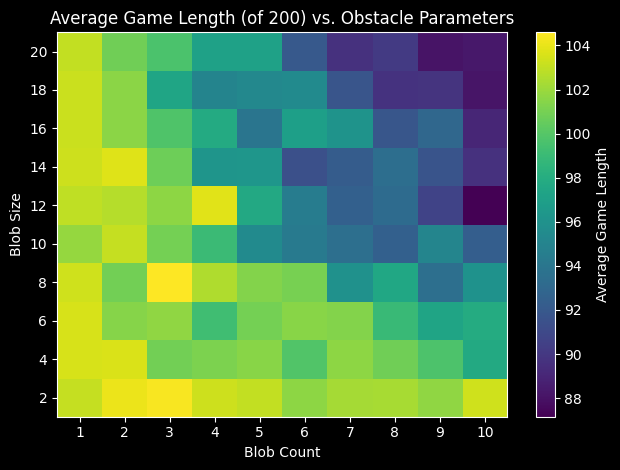

In [24]:
# ---- Visualization as heat map ----
fig, ax = plt.subplots()

# imshow will use the default colormap; no custom colors specified
im = ax.imshow(avg_lengths, origin="lower", aspect="auto")

# Tick labels correspond to your parameter values
ax.set_xticks(np.arange(len(max_counts)))
ax.set_xticklabels(max_counts)
ax.set_yticks(np.arange(len(max_sizes)))
ax.set_yticklabels(max_sizes)

ax.set_xlabel("Blob Count")
ax.set_ylabel("Blob Size")
ax.set_title("Average Game Length (of 200) vs. Obstacle Parameters")

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Average Game Length")

plt.tight_layout()
plt.show()

## Maze Vision Ability Analysis
The following code investigate how well the HTN performs as the agent's vision ability increases ie it can see farther in the maze.

In [ ]:
small_board_results: tuple[list[float], ...] = ([], [], [])
medium_board_results: tuple[list[float], ...] = ([], [], [])
large_board_results: tuple[list[float], ...] = ([], [], [])

obstacle_schemes = [
    DisjointBlobs(max_count=6, max_size=5),   # normal
    DisjointBlobs(max_count=15, max_size=2),  # many small
    DisjointBlobs(max_count=3, max_size=15),  # big
]

base_seed = 42

def avg_runs(game_factory, seed_start: int, runs: int = 200) -> float:
    """Run multiple games with incremental seeds and return average length."""
    return sum(game_factory(seed_start + k) for k in range(runs)) / runs

for i in range(3, 12, 2):
    print(i)

    for idx, obstacle_gen in enumerate(obstacle_schemes):

        # ---- small board ----
        small_board_results[idx].append(
            avg_runs(
                lambda seed: DictBasedHTN(
                    h=12, w=12, n=11, m=i,
                    num_fake_targets=5,
                    obstacle_scheme=obstacle_gen
                ).play_game(seed),
                base_seed
            )
        )

        # ---- medium board ----
        medium_board_results[idx].append(
            avg_runs(
                lambda seed: DictBasedHTN(
                    h=24, w=24, n=11, m=i,
                    num_fake_targets=5,
                    obstacle_scheme=obstacle_gen
                ).play_game(seed),
                base_seed
            )
        )

        # ---- large board ----
        large_board_results[idx].append(
            avg_runs(
                lambda seed: DictBasedHTN(
                    h=36, w=36, n=11, m=i,
                    num_fake_targets=5,
                    obstacle_scheme=obstacle_gen
                ).play_game(seed),
                base_seed
            )
        )

stride: 3
stride: 5
stride: 7
stride: 9
stride: 11


### Plotting individually

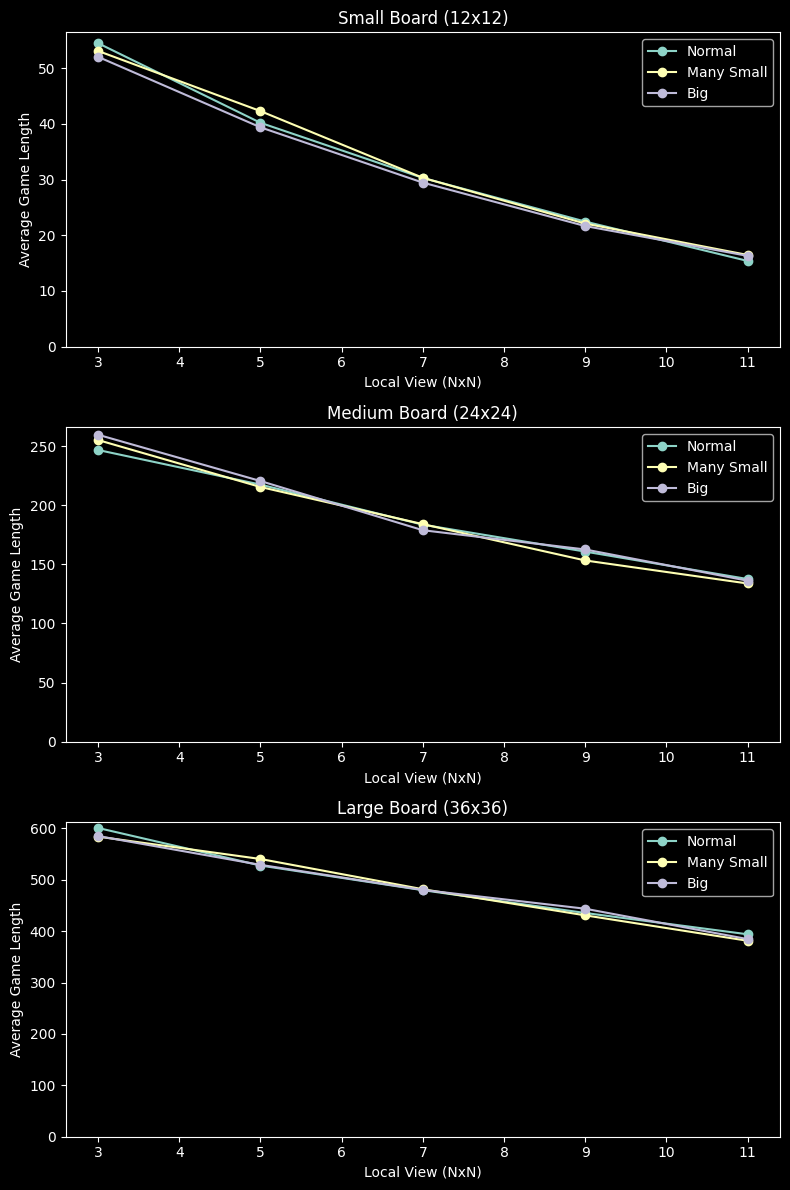

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

board_sets = [
    (axes[0], small_board_results, "Small Board (12x12)"),
    (axes[1], medium_board_results, "Medium Board (24x24)"),
    (axes[2], large_board_results, "Large Board (36x36)"),
]

for ax, board_result, title in board_sets:
    for label, series in zip(labels, board_result):
        ax.plot(viewing_distances, series, marker="o", label=label)
    ax.set_title(title)
    ax.set_xlabel("Local View (NxN)")
    ax.set_ylabel("Average Game Length")
    ax.set_ylim(bottom=0)
    ax.legend()

plt.tight_layout()
plt.show()


### Plotting together

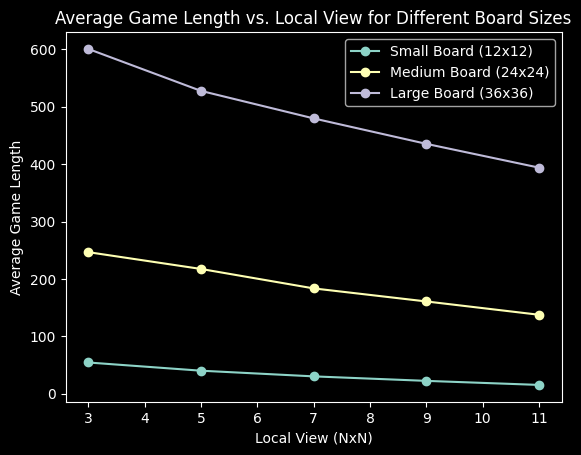

In [20]:
plt.plot(viewing_distances, small_board_results[0], marker='o', label='Small Board (12x12)')
plt.plot(viewing_distances, medium_board_results[0], marker='o', label='Medium Board (24x24)')
plt.plot(viewing_distances, large_board_results[0], marker='o', label='Large Board (36x36)')
plt.xlabel('Local View (NxN)')
plt.ylabel('Average Game Length')
plt.title('Average Game Length vs. Local View for Different Board Sizes')
plt.legend()
plt.show()

## Effects of car obscurity on HTN performance

In [9]:
small_board_results2: tuple[list[float], ...] = ([], [], [])
medium_board_results2: tuple[list[float], ...] = ([], [], [])
large_board_results2: tuple[list[float], ...] = ([], [], [])

obstacle_schemes = [
    DisjointBlobs(max_count=6, max_size=5),   # normal
    DisjointBlobs(max_count=15, max_size=2),  # many small
    DisjointBlobs(max_count=3, max_size=15),  # big
]

base_seed = 42

def avg_runs(game_factory, seed_start: int, runs: int = 200) -> float:
    """Run multiple games with incremental seeds and return average length."""
    return sum(game_factory(seed_start + k) for k in range(runs)) / runs

for i in range(2, 12, 1):
    print(i)

    for idx, obstacle_gen in enumerate(obstacle_schemes):

        # ---- small board ----
        small_board_results2[idx].append(
            avg_runs(
                lambda seed: DictBasedHTN(
                    h=12, w=12, n=11, m=i,
                    num_fake_targets=5,
                    obstacle_scheme=obstacle_gen
                ).play_game(seed),
                base_seed
            )
        )

        # ---- medium board ----
        medium_board_results2[idx].append(
            avg_runs(
                lambda seed: DictBasedHTN(
                    h=24, w=24, n=11, m=i,
                    num_fake_targets=5,
                    obstacle_scheme=obstacle_gen
                ).play_game(seed),
                base_seed
            )
        )

        # ---- large board ----
        large_board_results2[idx].append(
            avg_runs(
                lambda seed: DictBasedHTN(
                    h=36, w=36, n=11, m=i,
                    num_fake_targets=5,
                    obstacle_scheme=obstacle_gen
                ).play_game(seed),
                base_seed
            )
        )

2
3
4
5
6
7
8
9
10
11


### Plotting individually

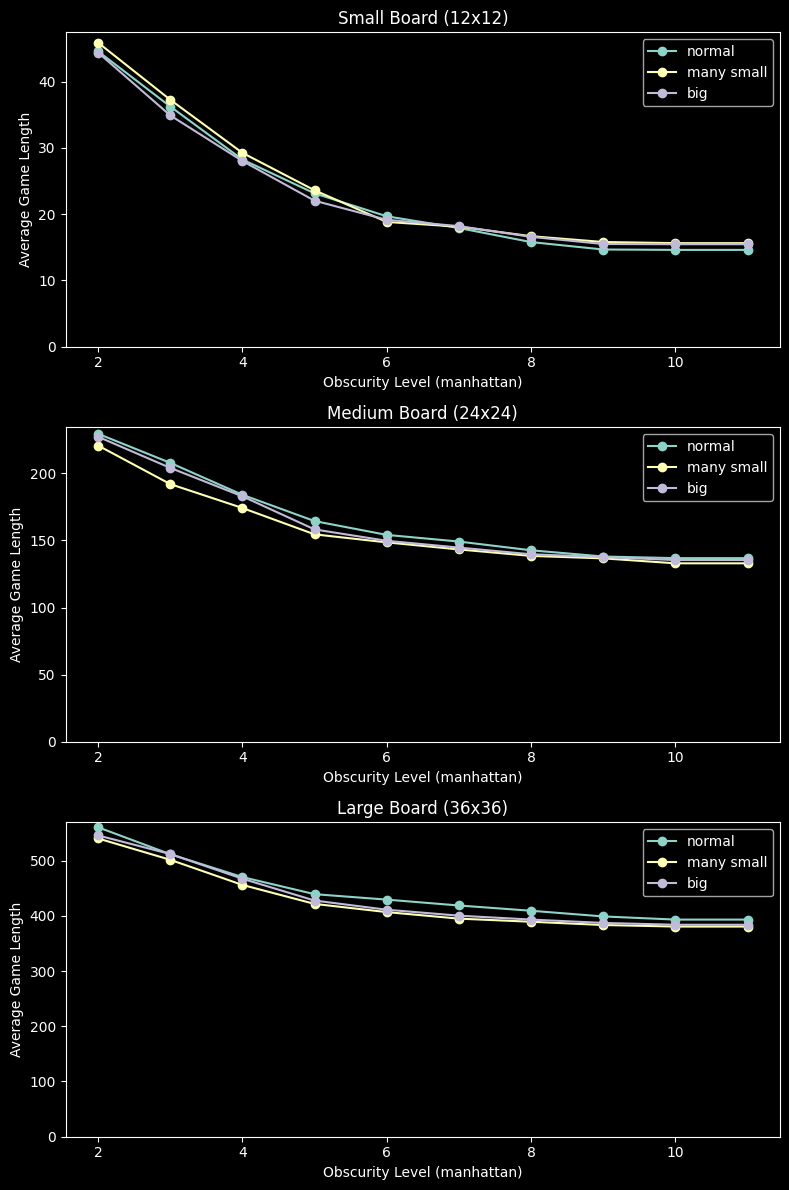

In [11]:
viewing_distances2 = list(range(2, 12, 1))
labels = ["normal", "many small", "big"]

fig, axes = plt.subplots(3, 1, figsize=(8, 12))

board_sets = [
    (axes[0], small_board_results2, "Small Board (12x12)"),
    (axes[1], medium_board_results2, "Medium Board (24x24)"),
    (axes[2], large_board_results2, "Large Board (36x36)"),
]

for ax, board_result, title in board_sets:
    for label, series in zip(labels, board_result):
        ax.plot(viewing_distances2, series, marker="o", label=label)
    ax.set_title(title)
    ax.set_xlabel("Obscurity Level (manhattan)")
    ax.set_ylabel("Average Game Length")
    ax.set_ylim(bottom=0)
    ax.legend()

plt.tight_layout()
plt.show()

### Plotting together

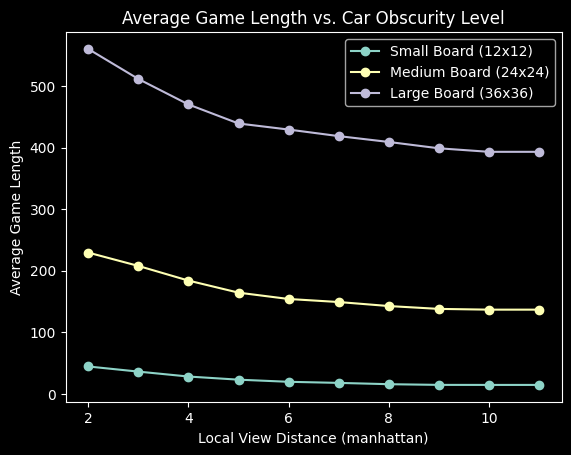

In [12]:
plt.plot(viewing_distances2, small_board_results2[0], marker='o', label='Small Board (12x12)')
plt.plot(viewing_distances2, medium_board_results2[0], marker='o', label='Medium Board (24x24)')
plt.plot(viewing_distances2, large_board_results2[0], marker='o', label='Large Board (36x36)')
plt.xlabel('Local View Distance (manhattan)')
plt.ylabel('Average Game Length')
plt.title('Average Game Length vs. Car Obscurity Level')
plt.legend()
plt.show()

## Assistance of helpers in finding cars

In [16]:
small_board_results3: tuple[list[float], ...] = ([], [], [])
medium_board_results3: tuple[list[float], ...] = ([], [], [])
large_board_results3: tuple[list[float], ...] = ([], [], [])

obstacle_schemes = [
    DisjointBlobs(max_count=6, max_size=5),   # normal
    DisjointBlobs(max_count=15, max_size=2),  # many small
    DisjointBlobs(max_count=3, max_size=15),  # big
]

base_seed = 42

def avg_runs(game_factory, seed_start: int, runs: int = 200) -> float:
    """Run multiple games with incremental seeds and return average length."""
    return sum(game_factory(seed_start + k) for k in range(runs)) / runs

for i in range(0, 8, 1):
    print(i)

    for idx, obstacle_gen in enumerate(obstacle_schemes):

        # ---- small board ----
        small_board_results3[idx].append(
            avg_runs(
                lambda seed: DictBasedHTN(
                    h=12, w=12, n=11, m=3,
                    num_fake_targets=5,
                    obstacle_scheme=obstacle_gen,
                    num_helpers=i,
                ).play_game(seed),
                base_seed
            )
        )

        # ---- medium board ----
        medium_board_results3[idx].append(
            avg_runs(
                lambda seed: DictBasedHTN(
                    h=24, w=24, n=11, m=3,
                    num_fake_targets=5,
                    obstacle_scheme=obstacle_gen,
                    num_helpers=i,
                ).play_game(seed),
                base_seed
            )
        )

        # ---- large board ----
        large_board_results3[idx].append(
            avg_runs(
                lambda seed: DictBasedHTN(
                    h=36, w=36, n=11, m=3,
                    num_fake_targets=5,
                    obstacle_scheme=obstacle_gen,
                    num_helpers=i,
                ).play_game(seed),
                base_seed
            )
        )

0
1
2
3
4
5
6
7


### Plotting individually

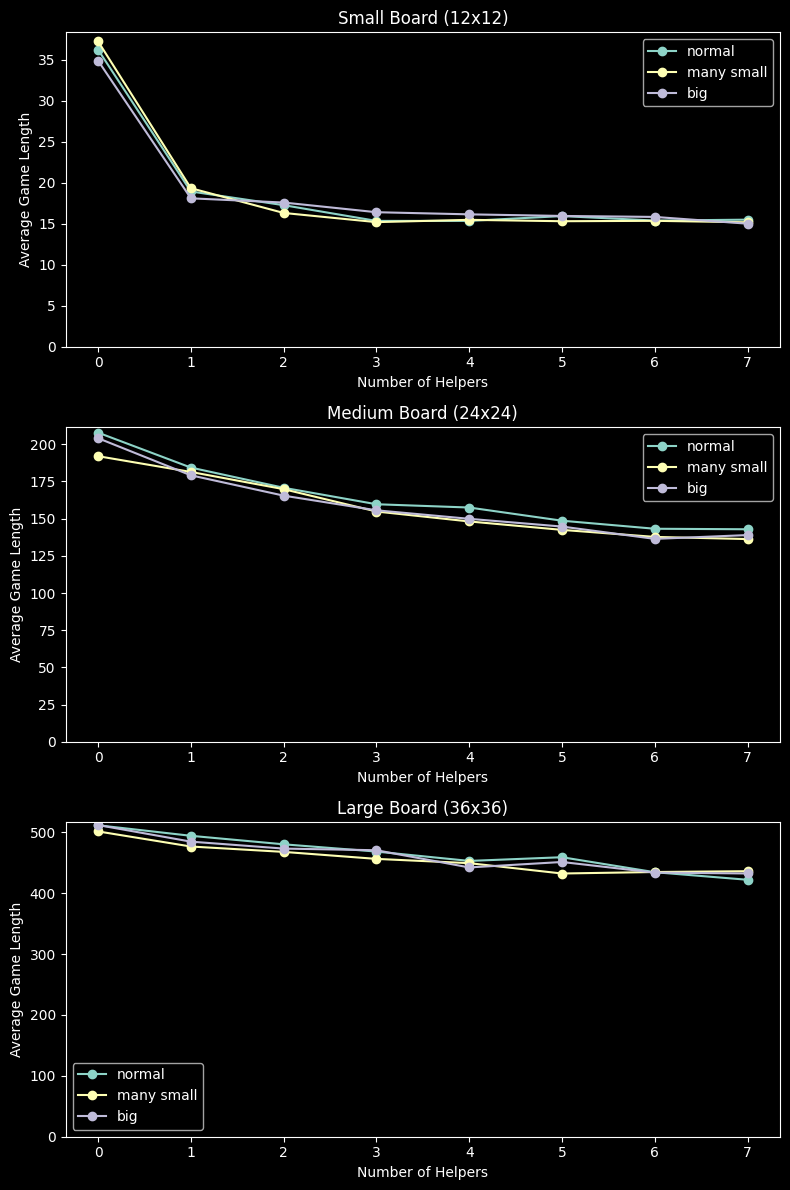

In [20]:
viewing_distances2 = list(range(0, 8, 1))
labels = ["normal", "many small", "big"]

fig, axes = plt.subplots(3, 1, figsize=(8, 12))

board_sets = [
    (axes[0], small_board_results3, "Small Board (12x12)"),
    (axes[1], medium_board_results3, "Medium Board (24x24)"),
    (axes[2], large_board_results3, "Large Board (36x36)"),
]

for ax, board_result, title in board_sets:
    for label, series in zip(labels, board_result):
        ax.plot(viewing_distances2, series, marker="o", label=label)
    ax.set_title(title)
    ax.set_xlabel("Number of Helpers")
    ax.set_ylabel("Average Game Length")
    ax.set_ylim(bottom=0)
    ax.legend()

plt.tight_layout()
plt.show()

### Plotting together

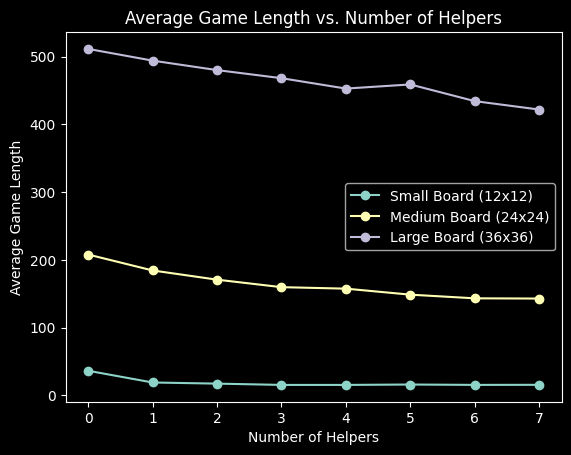

In [21]:
plt.plot(viewing_distances2, small_board_results3[0], marker='o', label='Small Board (12x12)')
plt.plot(viewing_distances2, medium_board_results3[0], marker='o', label='Medium Board (24x24)')
plt.plot(viewing_distances2, large_board_results3[0], marker='o', label='Large Board (36x36)')
plt.xlabel('Number of Helpers')
plt.ylabel('Average Game Length')
plt.title('Average Game Length vs. Number of Helpers')
plt.legend()
plt.show()